# Random forest

In [2]:
import os
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [3]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predicand)

In [4]:
dem_da = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Predictors. Load everything from relevant directory.

In [5]:
files = [path + "demand_predictors/" + i for i in os.listdir(path + "demand_predictors/")]

In [6]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [7]:
pred_ds.data_vars

Data variables:
    t2min     (region, time) float64 nan 289.1 289.3 290.0 ... 281.9 287.8 287.9
    t2m3      (region, time) float64 nan nan 293.0 293.7 ... 290.2 287.9 289.7
    msdwswrf  (region, time) float64 nan 293.4 257.6 298.1 ... 281.5 249.9 299.6
    cdd4      (region, time) float64 nan nan nan ... 0.221 0.221 -0.001519
    t2m       (region, time) float64 292.7 292.8 293.6 ... 287.1 289.8 292.2
    cdd3      (region, time) float64 nan nan 0.2243 ... -0.001518 -0.001519
    cdd       (region, time) float64 0.2843 0.1455 ... 5.631e-05 5.632e-05
    hdd4      (region, time) float64 nan nan nan 0.383 ... 2.467 2.565 2.572
    hdd       (region, time) float64 1.053 0.5182 0.3264 ... 4.067 1.35 0.06106
    mtpr      (region, time) float64 2.842e-05 4.244e-05 ... 1.614e-05 6.045e-06
    rh        (region, time) float64 92.39 91.39 91.05 ... 90.65 93.94 92.18
    w10       (region, time) float64 3.489 3.602 3.166 ... 1.758 3.059 3.369
    t2max     (region, time) float64 nan 297.4 2

## Define some functions

For a given region, get the data into a dataframe

In [8]:
def to_dataframe(target_da, predictors_ds, region):
    """
    Convert xarray data to pandas dataframe.
    """
    # Predictors to array
    predictors_arr = predictors_ds.sel(region=region, time=target_da["time"]).to_array("variable")
    # Data array of target and predictors
    da = xr.concat([
        predictors_arr,
        target_da.sel(region=region).expand_dims({"variable": ["demand"]})
    ], dim="variable")
    # Dataframe
    df = pd.DataFrame(
        da.transpose(),
        columns=da["variable"],
        index=target_da["time"]
    )
    return df

Set up a time column to either indicate:
1. day of week
2. weekend/weekday binary
3. winter/summer/transition
4. transition/(winter,summer) binary

In [9]:
def add_time_column(df, method):
    """
    Add a time column to df.
    
    df: dataframe to add to
    method: str indicating which method to use. Currently 'is_weekend',
            'month_sin', 'month_cos', 'month_int', 'season_int'
    """
    if method == "is_weekend":
        # Bool for weekend day or weekday
        new_col = (df.index.weekday > 4).astype("int16")
    elif method == "month_sin":
        new_col = np.sin((df.index.month - 1) * (2. * np.pi / 12))
    elif method == "month_cos":
        new_col = np.cos((df.index.month - 1) * (2. * np.pi / 12))
    elif method == "month_int":
        new_col = df.index.month
    elif method == "season_int":
        new_col = df.index.month % 12 // 3 + 1
    else:
        raise ValueError("Incorrect 'method'.")
    
    df[method] = new_col
    return df

Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [10]:
def split(df, target_name, test_size, random_state):
    """
    Apply train_test_split to dataframe
    
    df: pandas dataframe
    target_name: column name of df to target
    test_size: float, proportion of data to test
    random_state: int
    """
    y = np.array(df[target_name]) # target
    X = np.array(df.drop(target_name, axis=1)) # predictors
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

Train model and make predictions

In [11]:
def predict_forest(train_y, train_X, test_X, random_state, n_estimators=100, n_jobs=None):
    """
    Instantiate and fit a random forest model, return predictions.
    
    train_y: target for training set
    train_X: predictors for training set
    test_X: predictors for test set
    random_state: number for replication
    n_estimators: number of trees
    n_jobs: number of jobs to run in parallel
    """
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=n_jobs)
    rf.fit(train_X, train_y)
    return rf, rf.predict(test_X)

## Apply to the data

*Note:* I've tried various permutations of seasonal indices (months and seasons), but they are all of low variable importance. This is presumably because seasonal information is contained in temperature.

In [12]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
time_cols = ["is_weekend"]

region_dfs = {}
for region in dem_da.region.values:
    df = to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [13]:
region_dfs["NSW"].head()

,demand,is_weekend,t2min,t2m3,msdwswrf,cdd4,t2m,cdd3,cdd,hdd4,hdd,mtpr,rh,w10,t2max,hdd3,t2m4
2010-01-01,189098.854210,0,293.135916,295.652358,164.218843,0.230228,296.525003,0.236526,0.176162,0.173212,0.000324,0.000087,93.658535,3.132796,299.244528,0.173511,295.379525
2010-01-02,213642.465012,1,290.967947,295.889085,229.810077,0.199591,295.424110,0.179770,0.087857,0.174805,0.008797,0.000108,94.196278,2.557276,300.501642,0.173751,295.595364
2010-01-03,194617.495814,1,290.609908,294.763146,148.300158,0.134740,292.339987,0.136942,0.007749,0.220479,0.236494,0.000024,93.812825,2.931974,294.826772,0.236721,295.001880
2010-01-04,189128.506616,0,289.493653,293.841889,238.270861,0.115388,293.761230,0.046391,0.060270,0.223888,0.019122,0.000006,91.860632,2.919768,296.801895,0.241564,294.512735
2010-01-05,191152.737418,0,291.541431,294.200035,329.752634,0.115776,296.498553,0.124774,0.215896,0.223851,-0.000134,0.000003,91.115371,2.041179,300.815600,0.238905,294.506123


Write to csv

In [14]:
# region_dfs["NEM"].to_csv(path + "ML_variables/NEM_2010-2020.csv")

In [15]:
def compute_scores(y_true, y_pred, metrics):
    """
    Compute scores for a variety of metrics.
    
    y_true: observations
    y_predict: predictions
    metrics: list of scores from sklearn.metrics
    """
    scores = []
    for metric in metrics:
        s = metric(y_true, y_pred)
        scores.append(s)
    return scores

In [16]:
def dropcol(df, to_drop):
    """
    Drop columns from df
    """
    return df.drop(to_drop, axis=1)

In [17]:
# def rf_stats(df):
#     """
#     Return predictions, scores and importances of model.
    
#     df: dataframe
#     """
#     train_X, test_X, train_y, test_y = split(
#         df,
#         "demand",
#         test_size=0.2,
#         random_state=1
#     )
#     rf, predictions = predict_forest(
#         train_y,
#         train_X,
#         test_X,
#         random_state=666,
#         n_estimators=100,
#         n_jobs=5
#     )
#     importances = rf.feature_importances_
#     scores = compute_scores(test_y, predictions, metrics)
    
#     # Also compute correlation
#     cor, _ = pearsonr(test_y, predictions)
#     scores.append(cor)
#     return predictions, importances, scores

In [18]:
def rf_repeat(df, metrics, n_iter):
    """
    Fit a random forest n_iter times and compute importances and scores.
    
    TODO: randomise the model within each train-test split? At the moment its one model per split.
    """
    # Predictors
    pred_list = df.drop("demand", axis=1).columns
    
    # Empty arrays or lists to fill with results
    test_values = []
    predictions_list = []
    importances = np.zeros((n_iter, len(pred_list)))
    scores_arr = np.zeros((n_iter, len(metrics)+1))
    
    random = range(n_iter)
    for r in random:
        
        train_X, test_X, train_y, test_y = split(
            df,
            "demand",
            test_size=0.2,
            random_state=r
        )
        rf, predictions = predict_forest(
            train_y,
            train_X,
            test_X,
            random_state=r,
            n_estimators=100,
            n_jobs=5
        )
        
        test_values.append(test_y)
        predictions_list.append(predictions)
        importances[r, :] = rf.feature_importances_
        scores = compute_scores(test_y, predictions, metrics)
        # Also compute correlation
        cor, _ = pearsonr(test_y, predictions)
        scores.append(cor)
        scores_arr[r, :] = scores
        
    # test_values and predictions_list to array
    test_values_arr = np.array(test_values)
    predictions_arr = np.array(predictions_list)
        
    return test_values_arr, predictions_arr, importances, scores_arr

In [19]:
# def importances(r_dict, region, n_iter):
#     """
#     Get random forest importances n times.
#     """
    
#     df = r_dict[region]
    
#     predictors_list = df.drop("demand", axis=1).columns
    
#     seed_list = np.zeros((n_iter, len(predictors_list)))
#     random = range(n_iter)
#     for r in random:
#         train_X, test_X, train_y, test_y = split(
#             df,
#             "demand",
#             test_size=0.2,
#             random_state=r
#         )
#         rf, predictions = predict_forest(
#             train_y,
#             train_X,
#             test_X,
#             random_state=r,
#             n_estimators=100,
#             n_jobs=5
#         )
#         seed_list[r, :] = rf.feature_importances_
#     return seed_list
#     # importance_df[region] = rf.feature_importances_
#     # importances = rf.feature_importances_
#     # importance_dict[region] = [(f, i) for f, i in zip(predictors_list, importances)]

In [21]:
n_iter = 2

In [93]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE", "r"]
metrics = [r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [75]:
# %%time
# NEM_importances = importances(region_dfs, "NEM", 100)

CPU times: user 6min 17s, sys: 13.9 s, total: 6min 31s
Wall time: 3min 25s


Only need importances for now

In [123]:
%%time
_test_ys, _preds, importances, _scores = rf_repeat(region_dfs["NEM"], metrics, n_iter)

CPU times: user 7.45 s, sys: 236 ms, total: 7.69 s
Wall time: 3.99 s


In [23]:
def plot_importances(df, importances):
    """
    Boxplot that ranks importances
    """
    n = importances.shape[0]
    # Sort by mean of all runs
    _means = importances.mean(axis=0)
    _argsort = np.flip(np.argsort(_means))
    vals_sorted = importances[:, _argsort]
    names_sorted = df.drop("demand", axis=1).columns[_argsort]
    
    fig, ax = plt.subplots()
    _ = ax.boxplot(vals_sorted)
    _ = ax.set_xticklabels(names_sorted, rotation=90)
    ax.set_title("Variable importances ("+str(n)+" runs)")
    
    return names_sorted

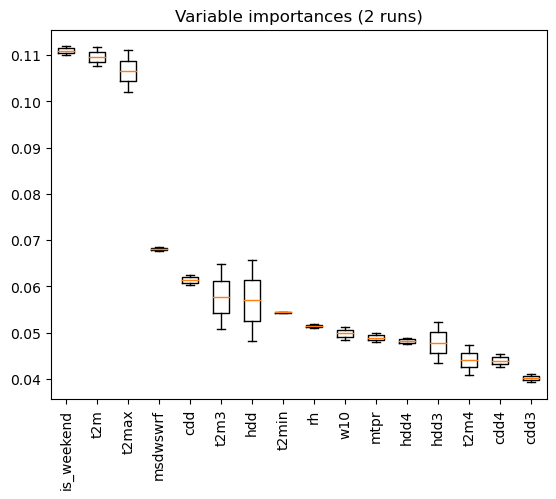

In [24]:
sorted_preds = plot_importances(region_dfs["NEM"], importances)

### Now we want to fit models but dropping the least important predictors

In [102]:
sorted_importances = np.flip(sorted_preds)
to_drop = []
    
# Drop least important, then the two least important etc.
for i in range(len(sorted_importances)):
    to_drop.append(sorted_importances[:i])

In [112]:
n_models = len(to_drop)

In [113]:
to_drop[:3]

[Index([], dtype='object'),
 Index(['cdd3'], dtype='object'),
 Index(['cdd3', 'cdd4'], dtype='object')]

In [124]:
_scores.shape

(2, 6)

In [125]:
%%time
df = region_dfs["NEM"]
models = []

test_ys = np.zeros((n_models, _test_ys.shape[0], _test_ys.shape[-1]))
preds = np.zeros(test_ys.shape)
imps = [] #np.zeros((n_models, importances.shape[0], importances.shape[-1]))
scores = np.zeros((n_models, _scores.shape[0], _scores.shape[-1]))

for i, d in enumerate(to_drop):
    # print(i)
    _df = dropcol(df, d)    
    y, p, imp, s = rf_repeat(_df, metrics, n_iter)
    test_ys[i,:,:] = y
    preds[i,:,:] = p
    # imps[i,:,:] = imp
    imps.append(imp)
    scores[i,:,:] = s
    # models.append((y, p, imp, s))

CPU times: user 1min 3s, sys: 4.45 s, total: 1min 7s
Wall time: 36 s


In [129]:
len(range(len(sorted_importances), 0, -1))

16

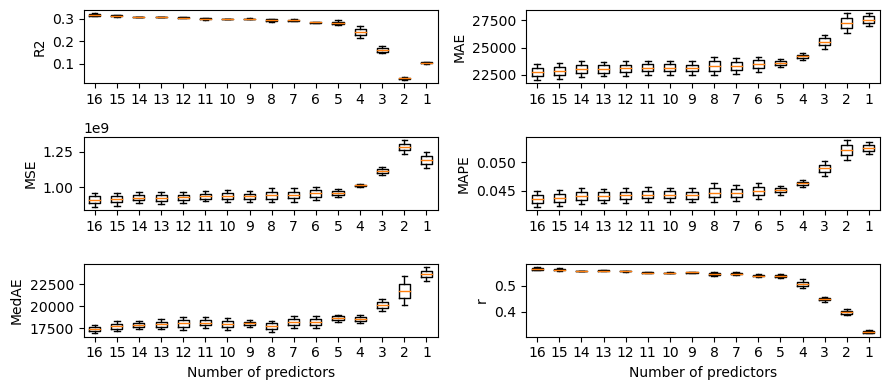

In [134]:
fig, ax = plt.subplots(len(metric_names)//2, 2, figsize=(9,4))
for i in range(len(metric_names)):
    _scores = scores[:,:,i].transpose()
#     if i == 0:
#         best_score = np.max(scores)
#     else:
#         best_score = np.min(scores)
        
#     ax[i].scatter(range(len(scores)), scores)
#     ax[i].scatter(np.where(scores == best_score)[0][0], best_score)

    a = ax.flatten()[i]

    _ = a.boxplot(_scores)
    # ax[i].set_xticks
    a.set_xticklabels(range(len(sorted_importances), 0, -1))
    
    a.set_ylabel(metric_names[i])
    
ax[-1,0].set_xlabel("Number of predictors")
ax[-1,1].set_xlabel("Number of predictors")
plt.tight_layout()

In [135]:
to_drop[-2:]

[Index(['cdd3', 'cdd4', 't2m4', 'hdd3', 'hdd4', 'mtpr', 'w10', 'rh', 't2min',
        'hdd', 't2m3', 'cdd', 'msdwswrf', 't2max'],
       dtype='object'),
 Index(['cdd3', 'cdd4', 't2m4', 'hdd3', 'hdd4', 'mtpr', 'w10', 'rh', 't2min',
        'hdd', 't2m3', 'cdd', 'msdwswrf', 't2max', 't2m'],
       dtype='object')]

In [120]:
def ts_scatter(ax0, ax1, pred, model_label):
    """
    Time series and scatter plot of predictions against obs
    """
    ax0.plot(test_y, label="Obs")
    ax0.plot(pred, label=model_label)
    ax0.legend()
    ax0.set_ylabel("Demand [MWh/day]")

    ax1.scatter(pred, test_y)
    ax1.plot(np.arange(4.5e5, 6.5e5, 100), np.arange(4.5e5, 6.5e5, 100), color="k", ls="--")
    ax1.set_xlabel("Predicted [MWh/day]")
    ax1.set_ylabel("Observed [MWh/day]")

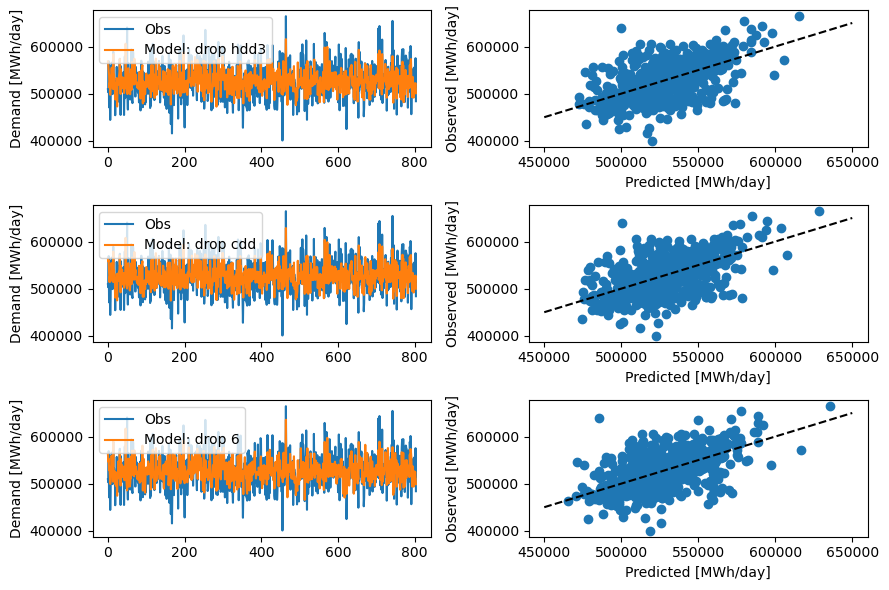

In [121]:
fig, ax = plt.subplots(3, 2, figsize=(9, 6))

for i, (p, l) in enumerate(zip(
    [models[7][0], models[10][0], models[26][0]],
    ["Model: drop hdd3", "Model: drop cdd", "Model: drop 6"]
)):
    ts_scatter(ax[i,0], ax[i,1], p, l)
plt.tight_layout()

In [152]:
predictors = region_dfs["NEM"].drop("demand", axis=1).columns

to_drop = []
predictions = []
scores = []
for i in range(len(predictors)):
    df = dropcol(region_dfs["NEM"], to_drop)
    predictors = df.drop("demand", axis=1).columns
    # print(predictors)
    p, imp, s = rf_stats(df)
    predictions.append(p)
    scores.append(s)
    
    least_imp = predictors[np.where(imp == np.min(imp))[0][0]]
    to_drop.append(least_imp)

In [154]:
scores[0]

[0.315715490695025,
 23540.969539480517,
 952369141.0125343,
 0.045065729152681096,
 18267.888450063794]

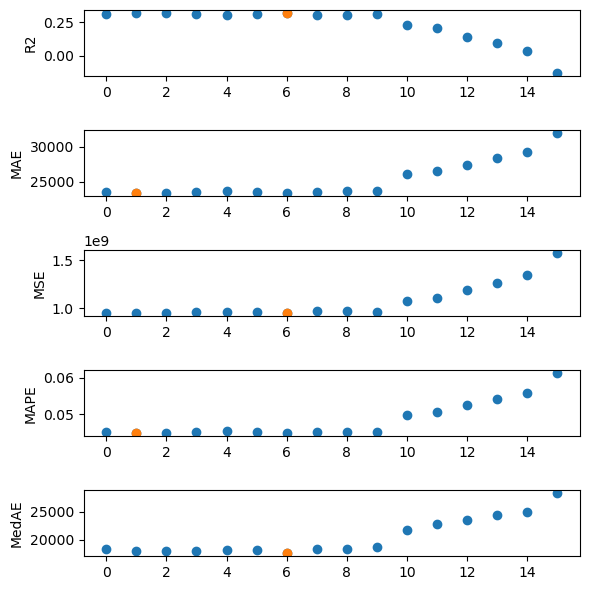

In [155]:
fig, ax = plt.subplots(len(metric_names), 1, figsize=(6,6))
for i in range(len(metric_names)):
    s = [x[i] for x in scores]
    if i == 0:
        best_score = np.max(s)
    else:
        best_score = np.min(s)
        
    ax[i].scatter(range(len(s)), s)
    ax[i].scatter(np.where(s == best_score)[0][0], best_score)
    
    ax[i].set_ylabel(metric_names[i])
plt.tight_layout()

In [158]:
to_drop[:9]

['cdd3', 't2m4', 'mtpr', 'rh', 'hdd3', 'w10', 't2min', 'cdd4', 'hdd']

In [159]:
to_drop[9:]

['is_weekend', 'hdd4', 'msdwswrf', 'cdd', 't2m3', 't2max', 't2m']

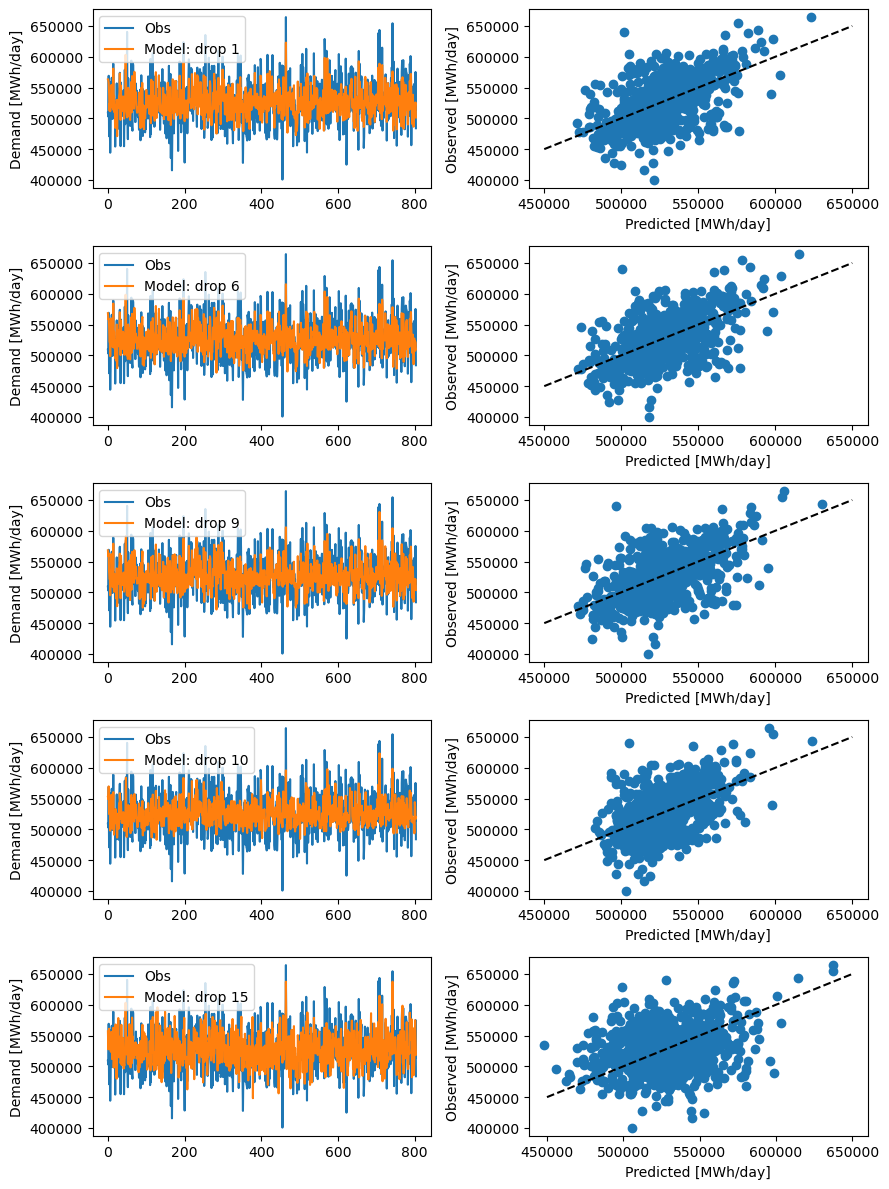

In [164]:
fig, ax = plt.subplots(5, 2, figsize=(9, 12))

for i, (p, l) in enumerate(zip(
    [predictions[1], predictions[6], predictions[9], predictions[10], predictions[15]],
    ["Model: drop 1", "Model: drop 6", "Model: drop 9", "Model: drop 10", "Model: drop 15"]
)):
    ts_scatter(ax[i,0], ax[i,1], p, l)
plt.tight_layout()

In [165]:
from scipy.stats import pearsonr

In [167]:
pearsonr(test_y, predictions[9])

(0.5573885448496092, 8.102872098244313e-67)